## Internet of Things Traffic Prediction using RNN Models

In [230]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import libraries for metrics and plotting
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [231]:
# Load the dataset
df = pd.read_csv("../dataset/esp32_1_data.csv")
df.head() # Display the first few rows of the dataset

,timestamp,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm)
0,2025-05-12 | 10:14:13,28.3,81.5,0.242920,0.054,0.0,-61
1,2025-05-12 | 10:14:15,28.5,80.2,0.336914,0.054,0.0,-61
2,2025-05-12 | 10:14:17,28.5,80.2,0.206543,0.054,0.0,-62
3,2025-05-12 | 10:14:19,28.5,80.2,0.434326,0.054,0.0,-65
4,2025-05-12 | 10:14:21,28.5,80.2,0.428711,0.054,0.0,-55


### Data Preprocessing

In [232]:
# Change the time column to datetime format and split it into date and time
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d | %H:%M:%S")

# Set the timestamp as the index
df.set_index("timestamp", inplace=True)
df_resampled = df.resample("min").mean()

# Check the shape of the dataset
print(f"Shape of the dataset: {df_resampled.shape}")

# Check the missing values in the dataset
print(f"Missing values in the dataset:\n{df_resampled.isnull().sum()}")

Shape of the dataset: (1896, 6)
Missing values in the dataset:
temperature              117
humidity(%)              117
latency(ms)              117
throughput(bytes/sec)    117
packet_loss(%)           117
rssi(dBm)                117
dtype: int64


In [233]:
# Impute missing values using mean of the column
df_resampled.fillna(df_resampled.mean(), inplace=True)

# Check the missing values after imputation
print(f"Missing values after imputation:\n{df_resampled.isnull().sum()}")

Missing values after imputation:
temperature              0
humidity(%)              0
latency(ms)              0
throughput(bytes/sec)    0
packet_loss(%)           0
rssi(dBm)                0
dtype: int64


In [234]:
# Show the data in 24 hours from 12:00:00 to 12:00:00
df_one_day_format = df_resampled.loc["2025-05-12 12:00:00":"2025-05-13 12:00:00"]

# Check the data
df_one_day_format.head()

,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm)
timestamp,,,,,,
2025-05-12 12:00:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:01:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:02:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:03:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:04:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011


C:\Users\Fadel\AppData\Local\Temp\ipykernel_30188\2447708053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_day_format["rolling_mean_latency"] = df_one_day_format["latency(ms)"].rolling(window=15, min_periods=1).mean()


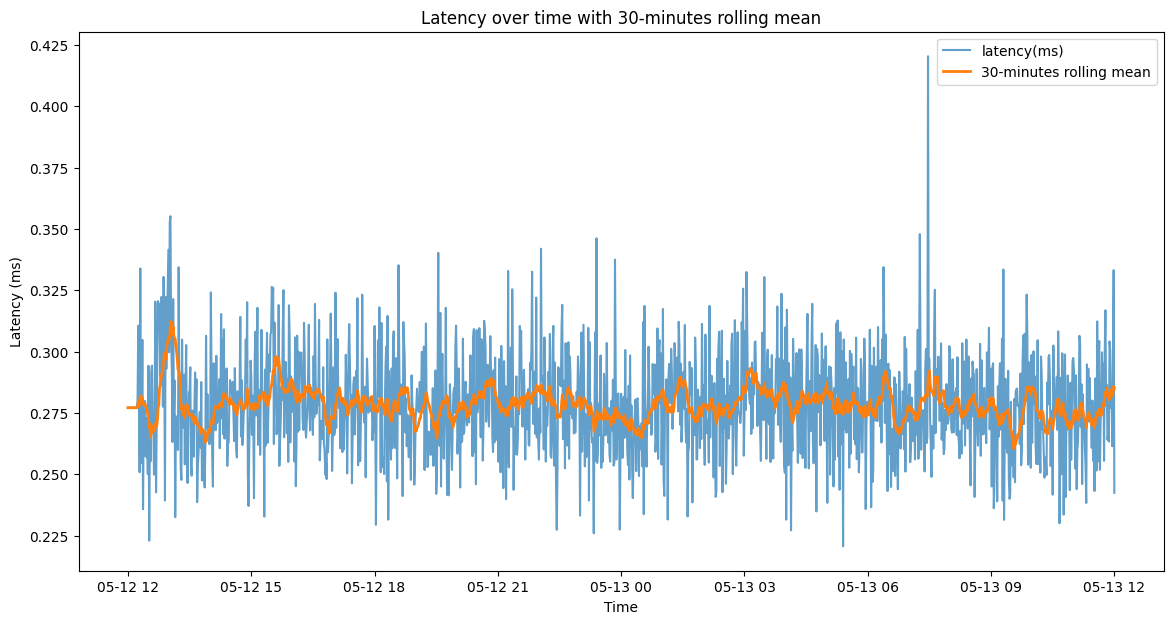

In [235]:
# Perform a rolling mean with a window of 30 minutes
df_one_day_format["rolling_mean_latency"] = df_one_day_format["latency(ms)"].rolling(window=15, min_periods=1).mean()

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(df_one_day_format.index, df_one_day_format["latency(ms)"], label="latency(ms)", alpha=0.7)
plt.plot(df_one_day_format.index, df_one_day_format["rolling_mean_latency"], label="30-minutes rolling mean", linewidth=2)
plt.title("Latency over time with 30-minutes rolling mean")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [236]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df_one_day_format.drop(columns=["rolling_mean_latency"])
y = df_one_day_format["rolling_mean_latency"]

In [237]:
# Scale the data using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler

# Define two different scaler
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit the scalers
X_scaled = feature_scaler.fit_transform(X)
# Convert 1D to 2D array, which -1 means "as many rows as needed"
# and 1 means one column
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)) 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
  X_scaled, y_scaled, test_size=0.2,
  shuffle=False
)

### Data Visualization

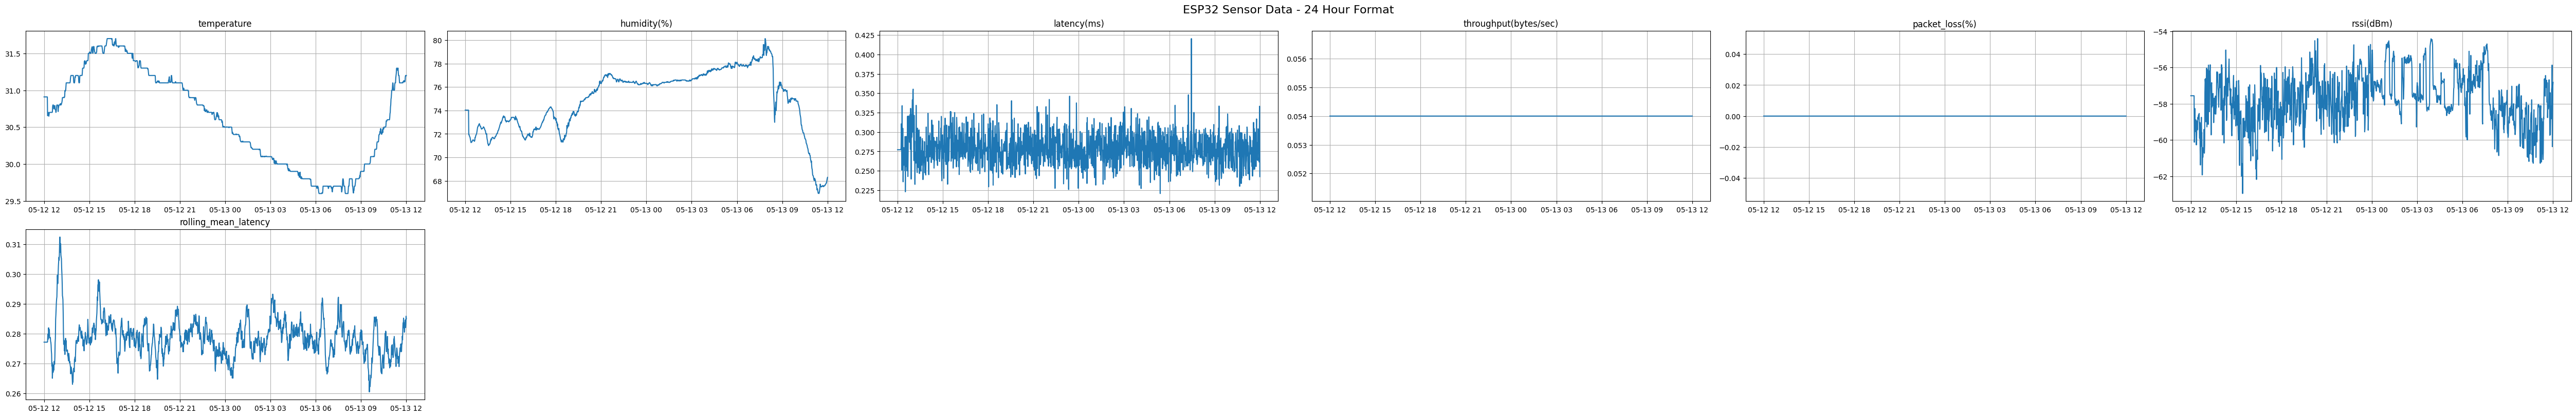

In [238]:
# Define num of rows and columns for the subplots
num_cols = 6
num_rows = int(np.ceil(len(df_one_day_format.columns) / num_cols))

# Create the figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(50, 8), constrained_layout=True)

# Flatten the axes array for iteration
axes = axes.flatten()

# Plot each column in a separate subplot
for i, column in enumerate(df_one_day_format.columns):
  axes[i].plot(df_one_day_format[column])
  axes[i].set_title(column)
  axes[i].grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

# Set the overall title for the figure
fig.suptitle("ESP32 Sensor Data - 24 Hour Format", fontsize=16)
plt.show()

## Simple RNN Model

In [239]:
# Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU

In [240]:
# Model building
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1))) # Input layer
model.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate 
model.add(SimpleRNN(units=100, return_sequences=False))
model.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate
model.add(Dense(units=1))  # Output layer for regression

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
model.summary()  # Display the model summary

c:\Project\rnn-iot-forecast\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_24 (SimpleRNN)       │ (None, 6, 100)         │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 6, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_25 (SimpleRNN)       │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [241]:
# Implement EarlyStopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=10,  # Number of epochs with no improvement after which training will be stopped
  restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model
history = model.fit(
  X_train.reshape(X_train.shape[0], X_train.shape[1], 1), # Reshape X_train for RNN input
  y_train.reshape(-1, 1), # Reshape y_train for RNN input
  epochs=100,
  callbacks=[early_stopping],
  validation_data=(
    X_test.reshape(X_test.shape[0], X_test.shape[1], 1), # Reshape X_test for RNN input
    y_test.reshape(-1, 1) # Reshape y_test for RNN input
  ),
  verbose=1
)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1714 - mae: 0.3311 - val_loss: 0.0127 - val_mae: 0.0890
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0284 - mae: 0.1264 - val_loss: 0.0102 - val_mae: 0.0800
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0214 - mae: 0.1155 - val_loss: 0.0107 - val_mae: 0.0836
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233 - mae: 0.1183 - val_loss: 0.0100 - val_mae: 0.0781
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0201 - mae: 0.1105 - val_loss: 0.0101 - val_mae: 0.0785
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0206 - mae: 0.1072 - val_loss: 0.0112 - val_mae: 0.0863
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0190 - mae: 0.1052 - val_loss: 0.0110 - val_mae: 0.0850
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - mae: 0.1054 - val_loss: 0.0103 - val_mae: 0.0811
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.01

### RNN Model Predict

In [242]:
# Predict on the test set
predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# Inverse transform the predictions to get the actual values
predictions = target_scaler.inverse_transform(predictions)

# Using y_test unscaled values for evaluation
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Perform evaluation with metrics
mae = mean_absolute_error(y_test_unscaled, predictions)
mse = mean_squared_error(y_test_unscaled, predictions)
r2 = r2_score(y_test_unscaled, predictions)

# Print the evaluation metrics
print("Peformance of SimpleRNN Model")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Peformance of SimpleRNN Model
Mean Absolute Error: 0.004056814377955595
Mean Squared Error: 2.7082443706638654e-05
R-squared: 0.11296223119551296


## LSTM Model

In [243]:
# Model building
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1))) # Input layer
model_lstm.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate
model_lstm.add(LSTM(units=100, return_sequences=False))
model_lstm.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate
model_lstm.add(Dense(units=1))  # Output layer for regression

# Compile the model
model_lstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])
model_lstm.summary()

c:\Project\rnn-iot-forecast\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 6, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 6, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [244]:
# Model training
history_lstm = model_lstm.fit(
  X_train.reshape(X_train.shape[0], X_train.shape[1], 1), # Reshape X_train for LSTM input
  y_train.reshape(-1, 1), # Reshape y_train for LSTM input
  callbacks=[early_stopping],
  validation_data=(
    X_test.reshape(X_test.shape[0], X_test.shape[1], 1), # Reshape X_test for LSTM input
    y_test.reshape(-1, 1) # Reshape y_test for LSTM input
  ),
  epochs=100,
  verbose=1
)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.01

### LSTM Model Predict

In [245]:
# Predict on the test set
predictions_lstm = model_lstm.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# Inverse transform the predictions to get the actual values
predictions_lstm = target_scaler.inverse_transform(predictions_lstm)

# Using y_test unscaled values for evaluation
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Perform evaluation with metrics
mae = mean_absolute_error(y_test_unscaled, predictions_lstm)
mse = mean_squared_error(y_test_unscaled, predictions_lstm)
r2 = r2_score(y_test_unscaled, predictions_lstm)

# Print the evaluation metrics
print("Performance of LSTM Model")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Performance of LSTM Model
Mean Absolute Error: 0.0041870632422358394
Mean Squared Error: 2.7014768664848615e-05
R-squared: 0.11517880805701941


## GRU Model

In [246]:
# Model building
model_gru = Sequential()
model_gru.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1))) # Input layer
model_gru.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate
model_gru.add(GRU(units=100, return_sequences=False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units=1))  # Output layer for regression

# Compile the model
model_gru.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])
model_gru.summary()

c:\Project\rnn-iot-forecast\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_14 (GRU)                    │ (None, 6, 100)         │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 6, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_15 (GRU)                    │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,601 (357.82 KB)

 Trainable params: 91,601 (357.82 KB)

 Non-trainable params: 0 (0.00 B)

In [247]:
# Train the model
history_gru = model_gru.fit(
  X_train.reshape(X_train.shape[0], X_train.shape[1], 1), # Reshape X_train for GRU input
  y_train.reshape(-1, 1), # Reshape y_train for GRU input
  callbacks=[early_stopping],
  validation_data=(
    X_test.reshape(X_test.shape[0], X_test.shape[1], 1), # Reshape X_test for GRU input
    y_test.reshape(-1, 1) # Reshape y_test for GRU input
  ),
  epochs=100,
  verbose=1
)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.01

### GRU Model Predict

In [248]:
# Predict on the test set
predictions_gru = model_gru.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# Inverse transform the predictions to get the actual values
predictions_gru = target_scaler.inverse_transform(predictions_gru)

# Using y_test unscaled values for evaluation
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Perform evaluation with metrics
mae = mean_absolute_error(y_test_unscaled, predictions_gru)
mse = mean_squared_error(y_test_unscaled, predictions_gru)
r2 = r2_score(y_test_unscaled, predictions_gru)

# Print the evaluation metrics
print("Performance of GRU Model")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Performance of GRU Model
Mean Absolute Error: 0.0040927761433127
Mean Squared Error: 2.630676449525728e-05
R-squared: 0.1383682382909176


### Visualize Results

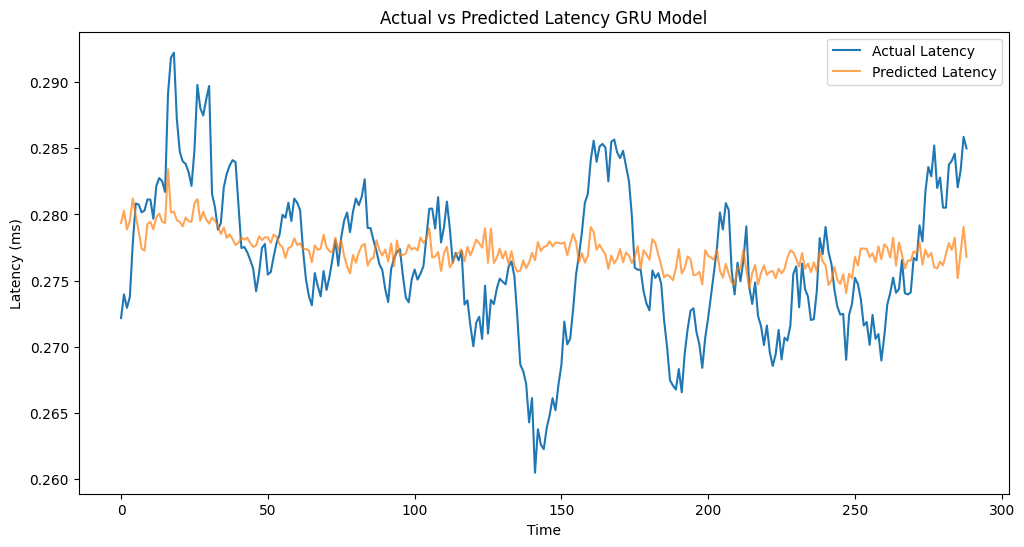

In [249]:
# Visualize the predictions for GRU model
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Latency")
plt.plot(predictions_gru, label="Predicted Latency", alpha=0.7)
plt.title("Actual vs Predicted Latency GRU Model")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

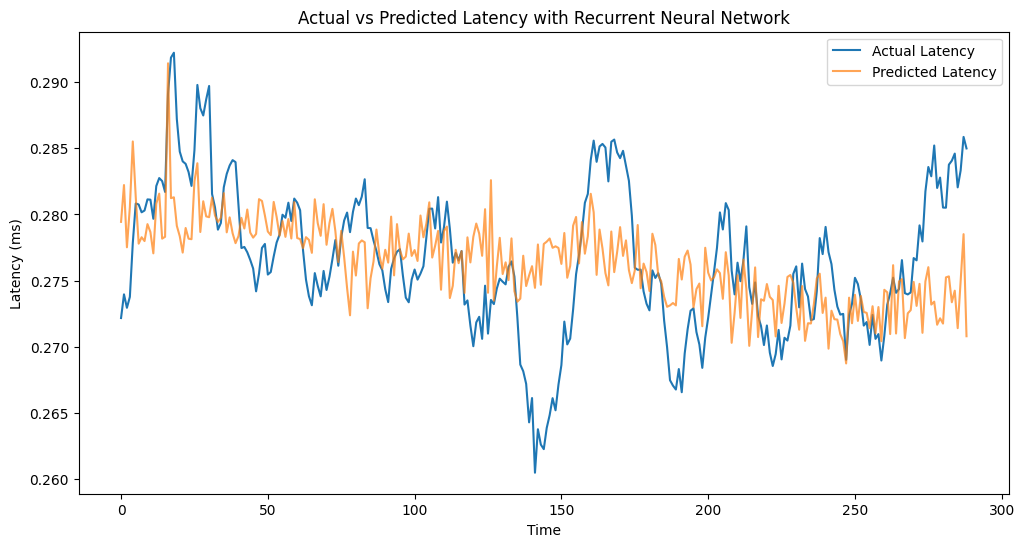

In [262]:
# Visualize the predictions for SimpleRNN model
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Latency")
plt.plot(predictions, label="Predicted Latency", alpha=0.7)
plt.title("Actual vs Predicted Latency with Recurrent Neural Network")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

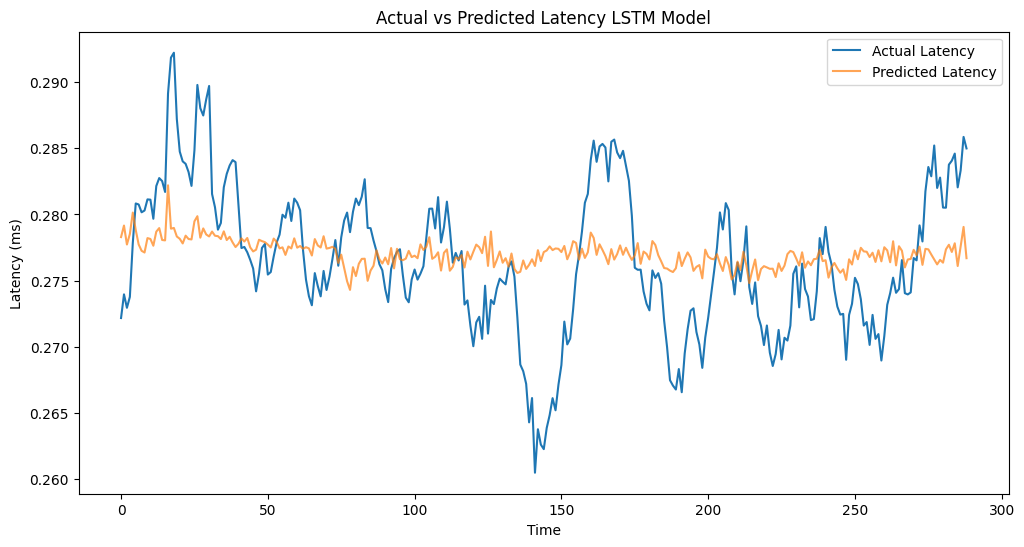

In [251]:
# Visualize the predictions for LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Latency")
plt.plot(predictions_lstm, label="Predicted Latency", alpha=0.7)
plt.title("Actual vs Predicted Latency LSTM Model")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()